# Coursework III: Poisson Image Editing

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

from scipy.sparse import lil_matrix
from scipy.sparse import linalg

## 1 Select a grayscale image

Load image

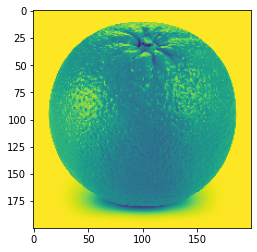

In [ ]:
# load image
img = cv2.imread("Orange.png")
img = cv2.resize(img, (200, 200))
img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_grey = img_grey/255.

# plot images
plt.imshow(img_grey)
plt.show()

**Mark out a region R using a polygon and remove it**

In [ ]:
# return all points' coordiantes contained in the selected region

def get_mask_points(img, polygon_coordinates):
    '''
    Arguments:
    img: source greyscale image
    polygon_coordinates: (m, 2) Ndarray of polygon's vertices

    Return: (k, 2) Ndarray of coordinates of points in the selected region
    '''
    mask_image = np.zeros(img.shape, np.float64)  
    mask_image = cv2.drawContours(mask_image, [polygon_coordinates], -1, color=1.0, thickness=-1)
    mask_points = np.array(np.where(mask_image == 1.0)).transpose()
    
    return mask_points

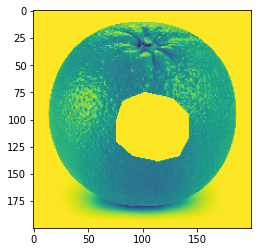

In [ ]:
# Mark out a region using a polygon

polygon = np.array([[102, 75], [82, 83], [76, 101], [76, 120], [91, 133], 
                    [114, 138], [134, 133], [142, 116], [142, 95], [128, 81]])


# Create a mask for points in the polygon
mask_points = get_mask_points(img_grey, polygon)

# Remove the polygon region
img_removed = img_grey.copy()

for point in mask_points:
    img_removed[point[0], point[1]] = 1.0

plt.imshow(img_removed)

**Fill in the empty region using Equation (2) in the paper**

The implementation can be resumed in three steps:
1. Define the boundary of the selected region
2. We put the Poisson equation in the form of $\mathbf{A}\mathbf{x} = \mathbf{b}$. To solve this, we first create a matrix A with all unknown variables and the connectivity with their neighbours. Also, it can be noticed that $\mathbf{A}$ is very sparse. In an image solution, the dimension of $\mathbf{A}$ would be $N * N$ ( with $N$ the number of pixels from the selected region, eg. $N \sim 1000$). But only $N * 4$ coefficients are involved in the one linear equation from system $\mathbf{A}$. So we need to store the coefficients in a sparse matrix with Scipy's sparse matrix library.
3. Then matrix b contains the boundary condition for the corresponding variable.

By solving $\mathbf{A}\mathbf{x} = \mathbf{b}$, we get the value of each pixel in the selected region.

In [ ]:
# find the boundary of the selected region and save the 
# coordinates of points from the boundary as a list

def find_boundary(img, mask_points):
    '''
    Arguments:
    img: source greyscale image
    mask_points: (k, 2) Ndarray of coordinates of points in the selected region

    Return: (n, 2) Ndarray of points on the boundary
    '''
    
    # iterate all points in the selected region
    # For its four neighbours:
    # if the neighbours in (not in the selected region) and (not yet in the boundary list) and (in the image scale)
    # add it to the list
    
    mask_points = mask_points.tolist()
    h, w = img.shape
    boundary = []


    for point in mask_points:
        x, y = point[0], point[1]
        neighbours = [[x-1, y], [x+1, y], [x, y-1], [x, y+1]]
        for n in neighbours:
            # check if the neighbour is in the image scale
            if n[0] >= 0 and n[0] < h and n[1] >= 0 and n[1] < w:
                # check if the neighbours is (not in the selected region) and (not yet in the boundary list)
                if (n not in mask_points) and (n not in boundary):
                    boundary.append(n)

    return np.array(boundary)

In [ ]:
def build_matrix_A(mask_points):
    '''
    Arguments:
    mask_points: (k, 2) Ndarray of coordinates of points in the selected region

    Return: (N, N) Sparse matrix of coefficients for unknown variables from the selected region
            with N = number of pixels in the selected region
    '''

    N = mask_points.shape[0]
    mask_points = mask_points.tolist()
    A = lil_matrix((N, N))
    
    for i in range(N):

        # put 4 on diagonal
        A[i,i] = -4

        # get the four neighbours of current variable,
        # if the neighbour is in the mask, add -1 to its index
        x, y = mask_points[i][0], mask_points[i][1]
        neighbours = [[x-1, y], [x+1, y], [x, y-1], [x, y+1]]
        for n in neighbours:
            if n in mask_points:
                index = mask_points.index(n)
                A[i, index] = 1
    
    return A.tocsr()

In [ ]:
def build_matrix_b(img, mask_points, boundary):
    '''
    Arguments:
    img: source greyscale image
    mask_points: (k, 2) Ndarray of coordinates of points in the selected region
    boundary: (n, 2) Ndarray of points on the boundary

    Return: (N, 1) Array contains boundary information
    '''
    
    N = mask_points.shape[0]
    mask_points = mask_points.tolist()
    boundary = boundary.tolist()
    b = np.zeros((N, 1))

    for i in range(N):

        # get neighbours of the current variable
        # check if they are in the boundary
        x, y = mask_points[i][0], mask_points[i][1]
        neighbours = [[x-1, y], [x+1, y], [x, y-1], [x, y+1]]
        for n in neighbours:
            if n in boundary:
                b[i] -= img[n[0], n[1]]

    return b

In [ ]:
# solve Ax = b

def solve_grey_scale(img, mask_points):
    '''
    Arguments:
    img: source greyscale image
    mask_points: (k, 2) Ndarray of coordinates of points in the selected region

    Return: (N, 1) Array containing the solution for each pixel in the selected region
    '''
    boundary =  find_boundary(img, mask_points)

    A = build_matrix_A(mask_points)
    b = build_matrix_b(img, mask_points, boundary)
    x = linalg.spsolve(A, b)

    return x


# rebuild image with the Poisson Equation solution

def rebuild_grey(img, mask_points, x):
    '''
    Arguments:
    img: source greyscale image
    mask_points: (k, 2) Ndarray of coordinates of points in the selected region
    x: (N, 1) Array containing the solution for each pixel in the selected region

    Return: rebuild image with the same size as img
    '''
    img_rebuild = img.copy()

    for i, point in enumerate(mask_points):
        img_rebuild[point[0], point[1]] = x[i]
    
    return img_rebuild

Solve $\mathbf{A}\mathbf{x} = \mathbf{b}$ and plot the result

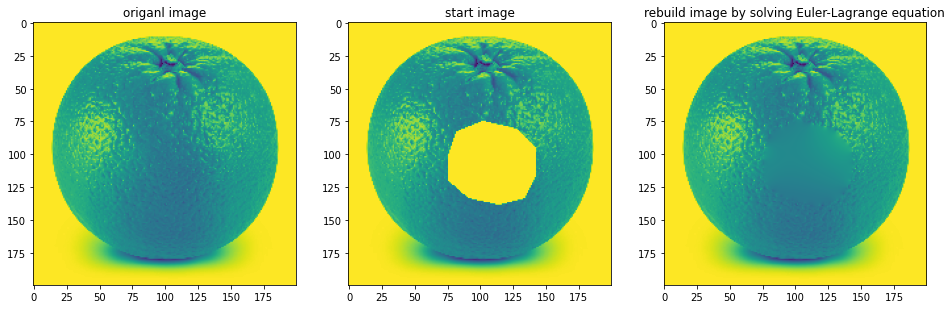

In [ ]:
# solve Ax = b
x = solve_grey_scale(img_grey, mask_points)

# fill the empty region with Poisson equation solution
img_rebuild = rebuild_grey(img_grey, mask_points, x)

# plot images
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (16,8)) 
ax1.title.set_text("origanl image")
ax1.imshow(img_grey)
ax2.title.set_text("start image")
ax2.imshow(img_removed)
ax3.title.set_text("rebuild image by solving Euler-Lagrange equation")
ax3.imshow(img_rebuild)
plt.show()

**Test the method in smooth regions and also in regions with edges (high-frequency)**

Test in smooth region

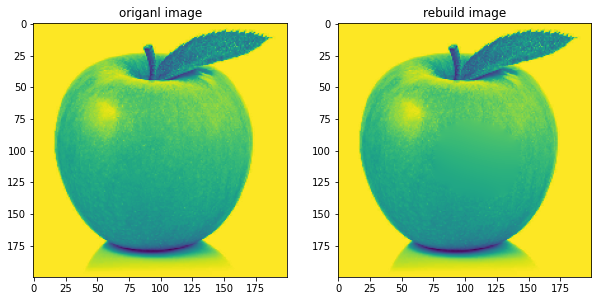

In [ ]:
# load image
smooth = cv2.imread("Apple.png")
smooth = cv2.resize(smooth, (200, 200))
smooth_grey = cv2.cvtColor(smooth, cv2.COLOR_BGR2GRAY)
smooth_grey = smooth_grey/255.

# create a mask for points in the polygon
mask_smooth = get_mask_points(smooth_grey, polygon)

# solve Ax = b and fill the empty region
x_smooth = solve_grey_scale(smooth_grey, mask_smooth)
smooth_rebuild = rebuild_grey(smooth_grey, mask_smooth, x_smooth)

# plot images
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,8)) 
ax1.title.set_text("origanl image")
ax1.imshow(smooth_grey)
ax2.title.set_text("rebuild image")
ax2.imshow(smooth_rebuild)
plt.show()

Test in region with edges

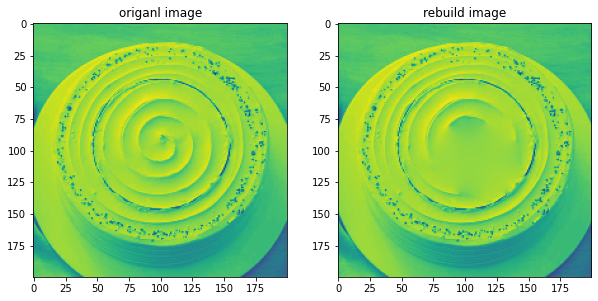

In [ ]:
# load image
edge = cv2.imread("Cake.png")
edge = cv2.resize(edge, (edge.shape[1]//3, edge.shape[0]//3))[5:205,70:270]
edge_grey = cv2.cvtColor(edge, cv2.COLOR_BGR2GRAY)
edge_grey = edge_grey/255.

# create a mask for points in the polygon
mask_edge = get_mask_points(edge_grey, polygon)

# solve Ax = b and fill the empty region
x_edge = solve_grey_scale(edge_grey, mask_edge)
edge_rebuild = rebuild_grey(edge_grey, mask_edge, x_edge)

# plot images
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,8)) 
ax1.title.set_text("origanl image")
ax1.imshow(edge_grey)
ax2.title.set_text("rebuild image")
ax2.imshow(edge_rebuild)
plt.show()

**Report the behavior as the size of the selected region increases**

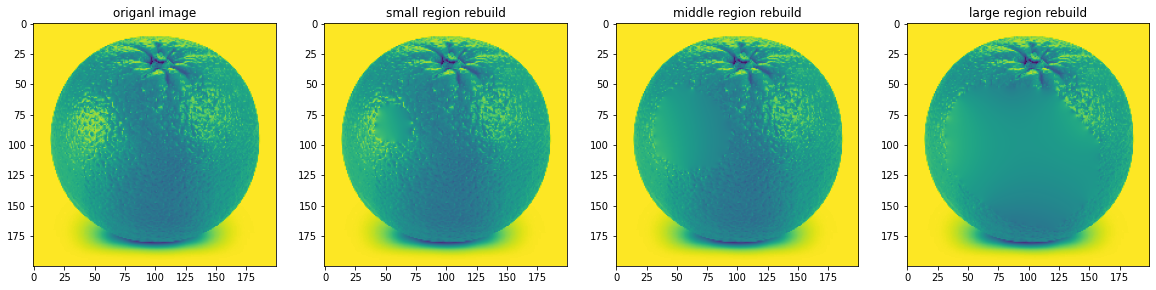

In [ ]:
# small selected region
polygon_small = np.array([[56,66],[46,69],[43,79],[42,91],[48,96],
                          [57,97],[66,97],[70,90],[71,80],[67,72]])

mask_small = get_mask_points(img_grey, polygon_small)
x_small = solve_grey_scale(img_grey, mask_small)
rebuild_small = rebuild_grey(img_grey, mask_small, x_small)

# middle selected region
polygon_middle = np.array([[53,50],[41,57],[34,69],[31,88],[34,108],
                           [54,119],[79,118],[91,105],[94,85],[78,61]])

mask_middle = get_mask_points(img_grey, polygon_middle)
x_middle = solve_grey_scale(img_grey, mask_middle)
rebuild_middle = rebuild_grey(img_grey, mask_middle, x_middle)

# large selected region
polygon_large = np.array([[58,52],[42,61],[32,81],[33,116],[52,139],
                          [84,162],[121,169],[156,139],[157,97],[119,54]])

mask_large = get_mask_points(img_grey, polygon_large)
x_large = solve_grey_scale(img_grey, mask_large)
rebuild_large = rebuild_grey(img_grey, mask_large, x_large)

# plot result
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20,8)) 
ax1.title.set_text("origanl image") # original :)
ax1.imshow(img_grey)
ax2.title.set_text("small region rebuild")
ax2.imshow(rebuild_small)
ax3.title.set_text("middle region rebuild")
ax3.imshow(rebuild_middle)
ax4.title.set_text("large region rebuild")
ax4.imshow(rebuild_large)
plt.show()

This result adequately satisfies the conditions we give in the Euler-Lagrange equation: 
1. The filled content is as smooth as possible.
2. The colour is also consistent with the background within the constraints of the pixel points from the boundary.

However, we notice that this method works better for a smooth region, while it gives only a blurred result for high-frequency texture.

And when we select a small region, the refill is small enough to be not noticeable. But when we increase the selection region, the blurred region becomes larger and larger, so more noticeable.

This blurred solution is caused by the missing information about how to fill the region in the Poisson equation. That is why we need to guide it with the guidance vector field $\mathbf{v}$, which will be introduced in the next section.

## 2 Seamless cloning for grayscale images

### (a) Importing gradients

Here we introduce $\mathbf{v} = \nabla g $, the gradient field extracted from the source image. So we have additional requirements for the rebuild task.

1. The gradient of the fill content should be as close as possible to $\mathbf{v}$.
2. The boundary pixel of the fill content should be consistent with the existing S so that the overlap is seamless.

To add the guidance gradient field to the Poisson equation, we first compute the Laplacian $\Delta g$ of the source selected region, then add them to their corresponding variable in matrix b.

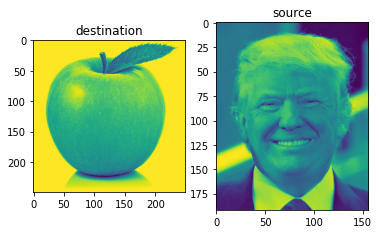

In [ ]:
# load source and destination image
source = cv2.imread("Trump.png")
source = cv2.resize(source, (source.shape[1]//2, source.shape[0]//2))
source = cv2.cvtColor(source, cv2.COLOR_BGR2GRAY)
source = source/255.

target = cv2.imread("Apple.png")
target = cv2.resize(target, (250, 250))
target = cv2.cvtColor(target, cv2.COLOR_BGR2GRAY)
target = target/255.

# plot images
f, (ax1, ax2) = plt.subplots(1, 2) 
ax1.title.set_text("destination")
ax1.imshow(target)
ax2.title.set_text("source")
ax2.imshow(source)
plt.show()

Define a polygon region in source and target image for cloning

In [ ]:
# define a polygon in the source image
source_polygon = np.array([[44,59],[38,80],[36,97],[39,116],[43,128],[49,136],[61,144],
                           [71,150],[83,152],[97,147],[103,139],[113,131],[119,119],[121,102],
                           [121,86],[119,68],[107,63],[94,55],[78,55],[61,55]])

# define a same polygon in the destination image with a transformation
x_translate, y_translate = 50, 50
target_polygon = np.copy(source_polygon)
target_polygon[:,0] += x_translate
target_polygon[:,1] += y_translate

# get list of points in the selected region from target and source
mask_target = get_mask_points(target, target_polygon)
mask_source = get_mask_points(source, source_polygon)

Clone simply the source image to the destination image

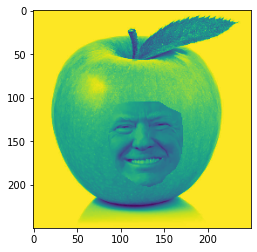

In [ ]:
# Cloning

cloning = target.copy()
for i, point in enumerate(mask_target):
    cloning[point[0], point[1]] = source[mask_source[i][0], mask_source[i][1]]

plt.imshow(cloning)
plt.show()

Compute Laplacian $\Delta g$ for source image and add it into matrix b

In [ ]:
def Laplacian_source(img, mask_points):
    '''
    Arguments:
    img: source greyscale image
    mask_points: (k, 2) Ndarray of coordinates of points in the selected region

    Return: (N, 1) Array containing Laplacian of the source image
    '''
    N = mask_points.shape[0]
    Laplacian = np.zeros(N)

    for i in range(N):
        x, y = mask_points[i][0], mask_points[i][1]
        Laplacian[i] = -4 * img[x, y] + img[x-1, y] + img[x+1, y] + img[x, y-1] + img[x, y+1]

    return Laplacian

In [ ]:
def build_matrix_b(img, mask_points, boundary, Laplacian):
    '''
    Arguments:
    img: source greyscale image
    mask_points: (k, 2) Ndarray of coordinates of points in the selected region
    boundary: (n, 2) Ndarray of points on the boundary
    Laplacian: (N, 1) Array containing Laplacian of the source image

    Return: (N, 1) Array containing boundary information
    '''
    N = mask_points.shape[0]
    mask_points = mask_points.tolist()
    boundary = boundary.tolist()
    b = np.zeros((N, 1))

    for i in range(N):
        
        b[i] += Laplacian[i]

        # get neighbours of the current variable
        # check if they are in the boundary
        x, y = mask_points[i][0], mask_points[i][1]
        neighbours = [[x-1, y], [x+1, y], [x, y-1], [x, y+1]]
        for n in neighbours:
            if n in boundary:
                b[i] -= img[n[0], n[1]]

    return b

In [ ]:
def solve_importing_gradiants(source, target, mask_source, mask_target):
    boundary = find_boundary(target, mask_target)
    source_Laplacian = Laplacian_source(source, mask_source)

    A = build_matrix_A(mask_target)
    b = build_matrix_b(target, mask_target, boundary, source_Laplacian)
    x = linalg.spsolve(A, b) 

    return x

Solve $\Delta f = \Delta g$ with $f|_{\partial\Omega} = f^∗|_{\partial\Omega}$

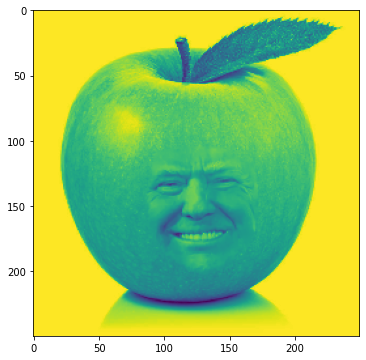

In [ ]:
# solve equation
x_importing_gradiants = solve_importing_gradiants(source, target, mask_source, mask_target)
# rebuild image
rebuild_importing_gradiants = rebuild_grey(target, mask_target, x_importing_gradiants)
# plot result
plt.figure(figsize = (6,6))
plt.imshow(rebuild_importing_gradiants)
plt.show()

The merge result is good enough on a smooth surface. However, there are still some merge marks on the boundary. And if we want to merge two images with very different texture features, it is better to use the method below.

### (b) Mixing gradients

Load target image with high frequency texture features

In [ ]:
target_high_freq = cv2.imread("Orange.png")
target_high_freq = cv2.resize(target_high_freq, (250, 250))
target_high_freq = cv2.cvtColor(target_high_freq, cv2.COLOR_BGR2GRAY)
target_high_freq = target_high_freq/255.

Define the guidance field $\mathbf{v}$ as a combination of source and target gradient fields

In [ ]:
def Laplacian_mixing_gradients(source, target, mask_source, mask_target):

    N = mask_source.shape[0]
    Laplacian = np.zeros(N)

    for i in range(N):
        
        # compare the gradient field of source and target
        # keep the gradient with higher absolute value

        x_source, y_source = mask_source[i][0], mask_source[i][1]
        x_target, y_target = mask_target[i][0], mask_target[i][1]
        neighbours = [[-1, 0], [1, 0], [0, -1], [0, 1]]
        
        for n in neighbours:
            gradient_source = source[x_source + n[0], y_source + n[1]] - source[x_source, y_source]
            gradient_target = target[x_target + n[0], y_target + n[1]] - target[x_target, y_target]

            if abs(gradient_source) > abs(gradient_target):
                Laplacian[i] += gradient_source
            else:
                Laplacian[i] += gradient_target

    return Laplacian


In [ ]:
def solve_mixing_gradiants(source, target, mask_source, mask_target):
    boundary = find_boundary(target, mask_target)
    mixing_Laplacian = Laplacian_mixing_gradients(source, target, mask_source, mask_target)
    
    A = build_matrix_A(mask_target)
    b = build_matrix_b(target, mask_target, boundary, mixing_Laplacian)
    x = linalg.spsolve(A, b)

    return x

Solve $\Delta f = \Delta g$ using **Mixing Gradients**

In [ ]:
# solve equation
x_mixing_gradiants = solve_mixing_gradiants(source, target_high_freq, mask_source, mask_target)
# rebuild image
rebuild_mixing_gradiants = rebuild_grey(target_high_freq, mask_target, x_mixing_gradiants)

Using **Importing Gradients** method for comparison

In [ ]:
# solve equation
x_importing_gradiants_hf = solve_importing_gradiants(source, target_high_freq, mask_source, mask_target)
# rebuild image
rebuild_importing_gradiants_hf = rebuild_grey(target_high_freq, mask_target, x_importing_gradiants_hf)

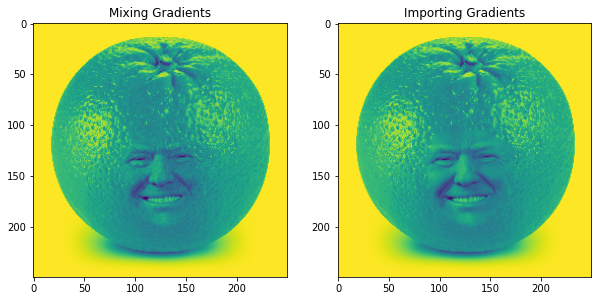

In [ ]:
# plot images
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,6)) 
ax1.title.set_text("Mixing Gradients")
ax1.imshow(rebuild_mixing_gradiants)
ax2.title.set_text("Importing Gradients")
ax2.imshow(rebuild_importing_gradiants_hf)
plt.show()

From the result shown above, the mixing gradient seamless cloning is more suitable for high-frequency backgrounds. It keeps the high frequency in each image by extracting the higher absolute value from the source and destination's gradients.

## 3 Seamless cloning for color images

Load source and destination image

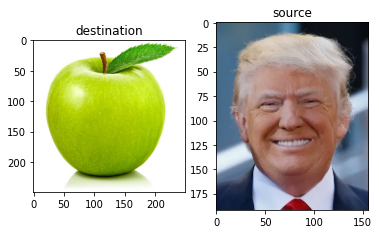

In [ ]:
source_rgb = cv2.imread("Trump.png")
source_rgb = cv2.resize(source_rgb, (source_rgb.shape[1]//2, source_rgb.shape[0]//2))
source_rgb = cv2.cvtColor(source_rgb, cv2.COLOR_BGR2RGB)
source_rgb = source_rgb/255.

target_rgb = cv2.imread("Apple.png")
target_rgb = cv2.resize(target_rgb, (250, 250))
target_rgb = cv2.cvtColor(target_rgb, cv2.COLOR_BGR2RGB)
target_rgb = target_rgb/255.

# plot images
f, (ax1, ax2) = plt.subplots(1, 2) 
ax1.title.set_text("destination")
ax1.imshow(target_rgb)
ax2.title.set_text("source")
ax2.imshow(source_rgb)
plt.show()

Process red, green, and blue channels separately

In [ ]:
def rebuild_rgb(source_rgb, target_rgb, mask_source, mask_target):
    
    # build new image with 3 channels
    rebuild_rgb = np.zeros(target_rgb.shape)

    # solve the equation for rgb channels separately
    for i in range(3):
        source_per_channel = source_rgb[:,:,i]
        target_per_channel = target_rgb[:,:,i]
        x_per_channel = solve_importing_gradiants(source_per_channel, target_per_channel, mask_source, mask_target)
        x_per_channel = np.clip(x_per_channel, 0., 1.)
        rebuild_rgb[:,:,i] = rebuild_grey(target_per_channel, mask_target, x_per_channel)

    return rebuild_rgb

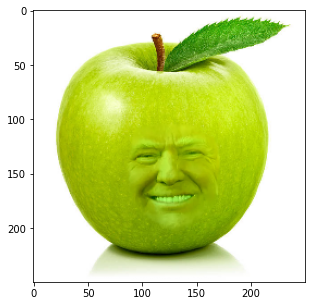

In [ ]:
rebuild_rgb_ = rebuild_rgb(source_rgb, target_rgb, mask_source, mask_target)

plt.figure(figsize = (5,5))
plt.imshow(rebuild_rgb_)
plt.show()

## 4 Selection editing effects

### Texture Flattening

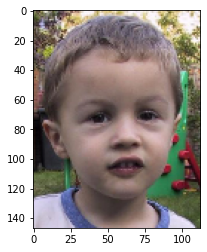

In [ ]:
# load image
img_tf = cv2.imread("Kid.png")
img_tf = cv2.resize(img_tf, (img_tf.shape[1]//4, img_tf.shape[0]//4))
img_tf = cv2.cvtColor(img_tf, cv2.COLOR_BGR2RGB)
img_tf = img_tf/255.

# plot images
plt.imshow(img_tf)
plt.show()

In [ ]:
def Laplacian_texture_flattening(img, mask, threshold):

    N = mask.shape[0]
    Laplacian = np.zeros(N)

    for i in range(N):
        
        # calculate each gradient
        # keep the gradient over a certain threshold

        x, y = mask[i][0], mask[i][1]
        neighbours = [[x-1, y], [x+1, y], [x, y-1], [x, y+1]]
        
        for n in neighbours:
            gradient = img[n[0], n[1]] - img[x, y]

            if abs(gradient) > threshold:
                Laplacian[i] += gradient

    return Laplacian

def solve_texture_flattening(img, mask, threshold):
    boundary = find_boundary(img, mask)
    Laplacian = Laplacian_texture_flattening(img, mask, threshold)
    
    A = build_matrix_A(mask)
    b = build_matrix_b(img, mask, boundary, Laplacian)
    x = linalg.spsolve(A, b)

    return x

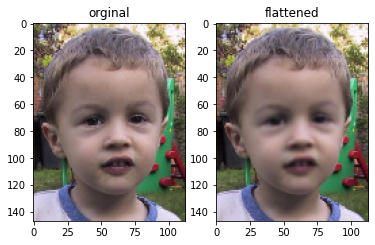

In [ ]:
'''
polygon_tf = np.array([[71,98],[52,131],[54,167],[62,203],[87,226],
                       [123,243],[161,223],[178,184],[188,128],[160,86]])
'''
polygon_tf = np.array([[29,33],[19,53],[19,81],[29,102],[48,120],
                       [72,122],[85,105],[92,79],[91,50],[62,35]])

mask_tf = get_mask_points(img_tf, polygon_tf)

# threshold for an edge
threshold = 0.7

# solve for rgb chanels
x_tf_r = solve_texture_flattening(img_tf[:,:,0], mask_tf, threshold)
x_tf_g = solve_texture_flattening(img_tf[:,:,1], mask_tf, threshold)
x_tf_b = solve_texture_flattening(img_tf[:,:,2], mask_tf, threshold)

# rebuild image
rebuild_tf_r = rebuild_grey(img_tf[:,:,0], mask_tf, x_tf_r)
rebuild_tf_g = rebuild_grey(img_tf[:,:,1], mask_tf, x_tf_g)
rebuild_tf_b = rebuild_grey(img_tf[:,:,2], mask_tf, x_tf_b)

rebuild_tf = np.zeros_like(img_tf)
rebuild_tf[:,:,0] = rebuild_tf_r
rebuild_tf[:,:,1] = rebuild_tf_g
rebuild_tf[:,:,2] = rebuild_tf_b


f, (ax1, ax2) = plt.subplots(1, 2) 
ax1.title.set_text("orginal")
ax1.imshow(img_tf)
ax2.title.set_text("flattened")
ax2.imshow(rebuild_tf)
plt.show()